# Redistributing smart pools BAL rewards
This is a post processing script that redistributes BAL rewards allocated to controllers of smart pools to the actual share holders of said controllers. It requires that liquidity mining script for the week have been run and block by block reports be stored in the reports directory. It also requires access to a view in Google BigQuery that provides running balances for a subset of ERC20 tokens and holders.

In [1]:
import os
import json
import pandas as pd
from google.cloud import bigquery
from google.cloud import bigquery_storage
from web3 import Web3
import matplotlib.pyplot as plt


WEEK = 22
WEEK_REPORTS_PATH = '../reports/' + str(WEEK)

Consider installing rusty-rlp to improve pyrlp performance with a rust based backend


In [2]:
# get receivers to redistribute
redistributers_dict = json.load(open('redistribute.json'))
redistributers_list = list(redistributers_dict.keys())

In [3]:
# get list of CRPs
sql = 'SELECT pool FROM `blockchain-etl.ethereum_balancer.CRPFactory_event_LogNewCrp`'
# Requires setting the environment variable GOOGLE_APPLICATION_CREDENTIALS 
# to the file path of the JSON file that contains a service account key 
# with access to the token_balances_subset view

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
crps = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)

redistributers_list.extend(crps['pool'].drop_duplicates().apply(Web3.toChecksumAddress))
print('Redistributers: {}'.format(redistributers_list))

Redistributers: ['0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F', '0x2005F663689C86Bc02Eb8B8F1B2C212fBB9641F0', '0xAEecc448801b3AC8B76CF71607599F60c451f2F3', '0xf95B43A6B135D8F610E4F0f3f74C61E508938D01', '0xDA684a074C06D91fbf586F8D53E25646d308980f', '0x580Ce6996F93bEAb139663E5FcD30e251E888ff8', '0x34A01C0A95B0592cc818Cd846c3Cf285d6C85A31', '0x591EFb9074CdB84ea6b86AA6A55102c7dE243C7B', '0x0646Ce4edC2dFc8B20c791f5e4f96cBa48aEf6a2', '0x952E56ce38Bb5D60791D7A9c59F160Ff195a0c7C', '0x3C226E17128ede6f730bB34b3f3bc56E72a30526', '0x78aCF4c9817Df26E230eD911b33563aa91e00593', '0x3D7753c4526f8657e383a46dC41eC97414941a80', '0x9292eDa388ccf9Bd3AfD8c643e5BbD53F809e5e0', '0x9827e4e8e2c10120340f9009275cC9610d1e4c63', '0x9A9E04aeB02ce63aEA855Ef22519cDfa7D04C269', '0xE0b3e6f0E545121B32d02FE0952c1cA56F8AD6DB', '0x3ddD8cB6ECc202726E89e6a1dC6F95A0e1f3a0C5']


In [4]:
# get snapshot rewards
files = os.listdir(WEEK_REPORTS_PATH)
snapshot_files = [f for f in files if '_' not in f]
rewards_to_redistribute = {}
for f in snapshot_files:
    # filter snapshot rewards
    receiver_rewards = json.load(open(WEEK_REPORTS_PATH + '/' + f))[1]
    redistributers_rewards = dict(filter(lambda key_value: key_value[0] in redistributers_list, receiver_rewards.items()))
    rewards_to_redistribute[f[:f.find('.')]] = redistributers_rewards

In [5]:
rewards_to_redistribute_df = pd.DataFrame(rewards_to_redistribute)
rewards_to_redistribute_df.index.name = 'redistributer'
rewards_to_redistribute_df.columns.name = 'block_number'
rewards_to_redistribute_df = rewards_to_redistribute_df.melt(ignore_index=False)
rewards_to_redistribute_df.reset_index(inplace=True)
rewards_to_redistribute_df['redistributer'] = rewards_to_redistribute_df['redistributer'].apply(lambda x: x.lower())
rewards_to_redistribute_df['value'] = rewards_to_redistribute_df['value'].astype(float)
rewards_to_redistribute_df['block_number'] = rewards_to_redistribute_df['block_number'].astype(int)
rewards_to_redistribute_df

,redistributer,block_number,value
0,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11165880,0.332253
1,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11161528,0.316237
2,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11153336,0.324007
3,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11131320,0.284833
4,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11150776,0.317435
...,...,...,...
174,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11154872,0.321614
175,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11139768,0.294221
176,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11139512,0.292717
177,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11149240,0.319898


In [6]:
# get redistributers' token holders
tokens = list(rewards_to_redistribute_df.redistributer.drop_duplicates())
snapshot_block_numbers = list(rewards_to_redistribute_df.block_number.drop_duplicates())
snapshot_block_numbers = [str(b) for b in snapshot_block_numbers]
sql = """
select * from `genuine-quasar-292419.ethereum_data.token_balances_subset`
where token_address in ({})
and block_number in ({})
and balance <> 0
""".format('\''+'\',\''.join(tokens)+'\'', 
           ','.join(snapshot_block_numbers))
print(sql)


select * from `genuine-quasar-292419.ethereum_data.token_balances_subset`
where token_address in ('0x49f2beff98ce62999792ec98d0ee4ad790e7786f')
and block_number in (11165880,11161528,11153336,11131320,11150776,11141560,11140536,11133624,11166392,11171512,11162040,11129784,11131064,11144888,11150520,11171768,11148472,11138232,11155128,11166648,11140280,11135416,11129272,11153592,11135928,11168952,11174072,11134904,11145144,11168440,11147704,11154104,11159736,11167672,11157944,11142584,11170744,11173304,11160504,11142072,11159224,11128760,11151032,11131832,11159480,11149496,11159992,11143864,11161016,11130808,11141048,11131576,11162552,11171000,11140024,11143608,11152824,11150264,11150008,11148984,11157688,11153848,11171256,11173816,11130296,11170488,11145400,11156152,11143096,11154616,11165624,11153080,11167160,11145912,11146168,11166136,11145656,11140792,11136952,11155640,11133880,11136440,11138488,11151544,11157432,11148728,11169976,11158456,11149752,11139000,11169464,11166904,111290

In [7]:
# Requires setting the environment variable GOOGLE_APPLICATION_CREDENTIALS 
# to the file path of the JSON file that contains a service account key 
# with access to the token_balances_subset view

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
running_balances = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
running_balances['balance'] = running_balances['balance'].astype(float)
running_balances = running_balances.rename(columns={"token_address": "redistributer", "address": "share_holder"})
running_balances.set_index(['block_number','redistributer','share_holder'], inplace=True)
running_balances

,,,balance
block_number,redistributer,share_holder,
11141304,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0x01673b193bbedee4c3748f3bf98e89bb80a8fa3d,9.670714e+20
11141560,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0x01673b193bbedee4c3748f3bf98e89bb80a8fa3d,9.670714e+20
11141816,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0x01673b193bbedee4c3748f3bf98e89bb80a8fa3d,9.670714e+20
11142072,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0x01673b193bbedee4c3748f3bf98e89bb80a8fa3d,9.670714e+20
11142328,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0x01673b193bbedee4c3748f3bf98e89bb80a8fa3d,9.670714e+20
...,...,...,...
11173304,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0xfe667f5bb242473bfa5e1eaf305703f2322795cf,3.634367e+22
11173560,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0xfe667f5bb242473bfa5e1eaf305703f2322795cf,3.634367e+22
11173816,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0xfe667f5bb242473bfa5e1eaf305703f2322795cf,3.634367e+22


In [8]:
shares = pd.DataFrame(running_balances['balance'])/pd.DataFrame(running_balances.groupby(['block_number','redistributer']).sum()['balance'])
shares.columns = ['perc_share']
shares.head()

perc_share
block_number redistributer                              share_holder                                          
11128760     0x49f2beff98ce62999792ec98d0ee4ad790e7786f 0x045b947e655b4ae46965223851cc7f922d1d19bc    0.000097
                                                        0x0a3cdf75aac28110b77b8a09f3f70427dfdc1738    0.000468
                                                        0x0d307d9c8b6d4aad162a662e4bbfba9ea96a5f81    0.000841
                                                        0x130608072c043cf1a5f3d0003da1db23d6f56ad2    0.010726
                                                        0x22f35a1c13b291b72a771bb061078b80dcf3a6e6    0.002089

In [9]:
rewards_to_redistribute_df.set_index(['block_number', 'redistributer'], inplace=True)
rewards_to_redistribute_df.fillna(0, inplace=True)
rewards_to_redistribute_df.head()

,,value
block_number,redistributer,
11165880,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0.332253
11161528,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0.316237
11153336,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0.324007
11131320,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0.284833
11150776,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0.317435


In [10]:
redistribution_df = pd.DataFrame(rewards_to_redistribute_df['value']*shares['perc_share']).dropna().reset_index()
redistribution_df.rename(columns={0: 'reward'}, inplace=True)
redistribution_df['share_holder'] = redistribution_df['share_holder'].apply(Web3.toChecksumAddress)
redistribution_df['redistributer'] = redistribution_df['redistributer'].apply(Web3.toChecksumAddress)

In [11]:
redistribution_df

,block_number,redistributer,share_holder,reward
0,11128760,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x045B947E655b4AE46965223851CC7F922d1D19bc,2.776499e-05
1,11128760,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x0a3cdf75aAc28110B77B8a09f3F70427dfDC1738,1.342066e-04
2,11128760,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x0d307D9C8B6D4aaD162A662E4bbFbA9Ea96A5F81,2.409742e-04
3,11128760,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x130608072C043CF1a5f3d0003Da1db23D6F56Ad2,3.073787e-03
4,11128760,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x22F35A1c13b291B72A771bb061078B80dCf3A6E6,5.986423e-04
...,...,...,...,...
11020,11174328,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0xeF8305E140ac520225DAf050e2f71d5fBcC543e7,7.646447e-05
11021,11174328,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0xf9c9C126F989df6Ea9DCe939232BE9164A69820d,8.505974e-18
11022,11174328,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0xf9FA4901b4Cb295D12db7662079e2a8DeDDdCE08,1.858480e-04
11023,11174328,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0xfC6EDEB989187ff13396450d5fB6eFc4860dB1f4,2.864428e-04


In [12]:
redistribution_df.loc[redistribution_df['reward']<0,'reward'] = 0

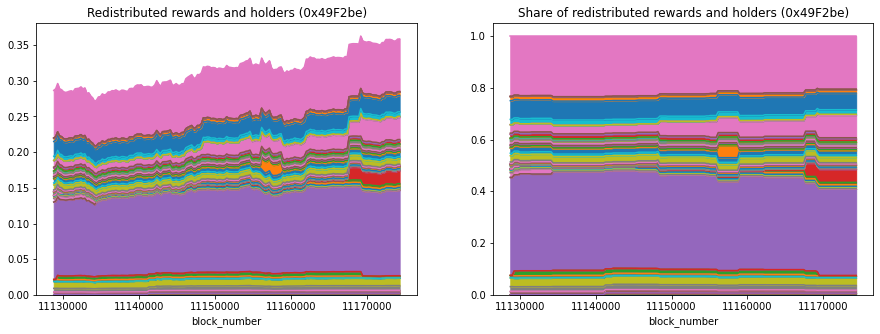

In [13]:
# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
actual_redistributers = list(redistribution_df.redistributer.drop_duplicates())
fig, axs = plt.subplots(ncols=2, nrows=len(actual_redistributers), figsize=(15, 5*len(actual_redistributers)))
for i,t in enumerate(actual_redistributers):
    areaplot = redistribution_df[redistribution_df.redistributer==t].pivot(index='block_number', 
                                                                           columns='share_holder', 
                                                                           values='reward')
    areaplot.plot.area(legend=False, ax=axs[2*i],
                       title='Redistributed rewards and holders ({})'.format(t[:8]));
    areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(legend=False, ax=axs[2*i+1],
                                                            title='Share of redistributed rewards and holders ({})'.format(t[:8]));
    axs.flat[2*i].ticklabel_format(axis='x', style='plain')
    axs.flat[2*i+1].ticklabel_format(axis='x', style='plain')

In [14]:
total_redistribution = redistribution_df.groupby('share_holder').sum()['reward']
total_redistribution

share_holder
0x01673B193BBEdeE4C3748f3BF98E89bb80A8fa3D    2.460417e-01
0x045B947E655b4AE46965223851CC7F922d1D19bc    5.209257e-03
0x0a3cdf75aAc28110B77B8a09f3F70427dfDC1738    2.517980e-02
0x0be5149120375A4B5ba59352D55173C9B0283C3d    9.827091e-03
0x0d307D9C8B6D4aaD162A662E4bbFbA9Ea96A5F81    4.521148e-02
                                                  ...     
0xeF8305E140ac520225DAf050e2f71d5fBcC543e7    1.297027e-02
0xf9FA4901b4Cb295D12db7662079e2a8DeDDdCE08    3.152444e-02
0xf9c9C126F989df6Ea9DCe939232BE9164A69820d    1.442824e-15
0xfC6EDEB989187ff13396450d5fB6eFc4860dB1f4    4.858781e-02
0xfe667F5bb242473BfA5E1EAF305703f2322795cF    1.250208e+01
Name: reward, Length: 67, dtype: float64

In [15]:
total_pre_redistribution = json.load(open(WEEK_REPORTS_PATH + '/_totalsPreRedistribute.json'))
total_post_redistribution = total_pre_redistribution.copy()
for index,value in total_redistribution.iteritems():
    old_value = float(total_pre_redistribution.get(index,0))
    new_value = old_value + value
    total_post_redistribution[index] = format(new_value, '.18f')

for r in redistribution_df['redistributer'].drop_duplicates():
    del total_post_redistribution[r]

In [16]:
print('BAL  pre-redistribution: {:.18f}'.format(sum([float(v) for v in total_pre_redistribution.values()])))
print('BAL post-redistribution: {:.18f}'.format(sum([float(v) for v in total_post_redistribution.values()])))

BAL  pre-redistribution: 144999.999999999301508069
BAL post-redistribution: 144999.999999999214196578


In [17]:
# json.dump(total_pre_redistribution, 
#           open(WEEK_REPORTS_PATH + '/_totalsPreRedistribute.json', mode='w'),
#           indent=4)

In [18]:
json.dump(total_post_redistribution, 
          open(WEEK_REPORTS_PATH + '/_totals.json', mode='w'),
          indent=4)